In [464]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [465]:
import numpy as np
import datetime as dt
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [466]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [467]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [468]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [469]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [470]:
# Save references to each table
meas = Base.classes.measurement
stat = Base.classes.station

In [471]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [472]:
query_date = session.query(meas.date).order_by(meas.date.desc()).first()
query_date = query_date[0]
lasty = dt.datetime.strptime(query_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(lasty)

2016-08-23 00:00:00


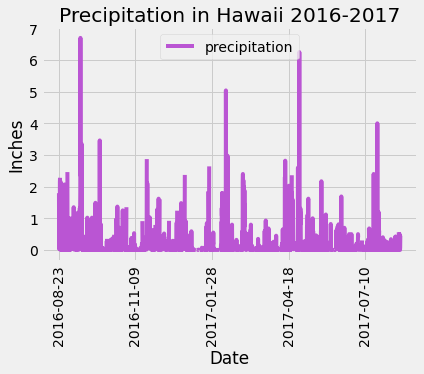

In [473]:

# Perform a query to retrieve the data and precipitation scores
results = session.query(meas.date, meas.prcp).filter(meas.date >= (dt.date(2017, 8, 23) - dt.timedelta(days=365))).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
dataframe = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
dataframe = dataframe.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
dataframe.plot(x='date', y='precipitation', rot=90, color="mediumorchid")
plt.xlabel("Date")
plt.legend(loc= 'best')
plt.ylabel("Inches")
plt.title("Precipitation in Hawaii 2016-2017")
plt.savefig('Output/Hawaii_Precipitation.png')

In [474]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dataframe.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [475]:
#query for total number of stations
session.query(func.count(stat.station)).all()

[(9)]

In [476]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(meas.station, func.count(meas.station)).group_by(meas.station).order_by(func.count(meas.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [477]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(meas.tobs), func.max(meas.tobs), func.avg(meas.tobs)).filter(meas.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

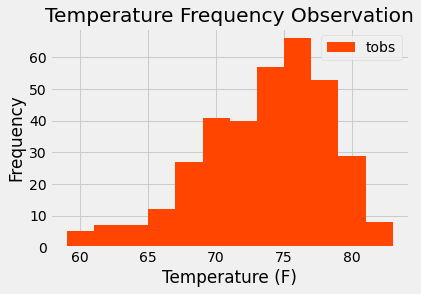

In [478]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table

results = session.query(meas.tobs).filter(meas.station == 'USC00519281').filter(meas.date >= (dt.date(2017, 8, 23) - dt.timedelta(days=365))).all()
dataframe2 = pd.DataFrame(results, columns=['tobs'])
dataframe2.plot.hist(bins=12, color="orangered")
plt.legend(loc= 'best')
plt.title("Temperature Frequency Observation")
plt.tight_layout()
plt.xlabel("Temperature (F)")
plt.savefig('Output/Hawaii_Temperature_Frequency.png')

## Bonus Challenge Assignment

In [479]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).filter(meas.date >= start_date).filter(meas.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [480]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

tmin, tavg, tmax = calc_temps((dt.date(2017, 8, 1) - dt.timedelta(days=365)).strftime("%Y-%m-%d"), (dt.date(2017, 8, 7) - dt.timedelta(days=365)).strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

72.0 77.79545454545455 83.0


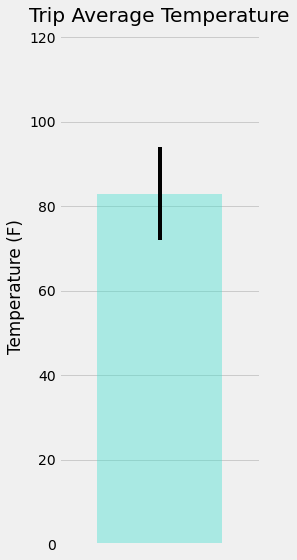

In [481]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1

bar = ax.bar(xpos, tmax, yerr=tmax-tmin, alpha=0.4, color='turquoise', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Average Temperature", ylabel="Temperature (F)")
ax.margins(.3, .3)
fig.tight_layout()
plt.savefig('Output/Hawaii_Trip_Temperature.png')

In [482]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-08-01'
end_date = '2016-08-07'

sel = [stat.station, stat.name, stat.latitude, 
       stat.longitude, stat.elevation, func.sum(meas.prcp)]

results = session.query(*sel).filter(meas.station == stat.station).filter(meas.date >= start_date).filter(meas.date <= end_date).group_by(stat.name).order_by(func.sum(meas.prcp).desc()).all()
print(results)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 6.019999999999998), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.6499999999999995), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.59), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.3000000000000003), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.03), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5700000000000001), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.18)]


In [483]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", meas.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [484]:
# Loop through strings to find temp normals for each date
nor = []
for date in pd.date_range('2017-08-01', '2017-08-07', freq='D').strftime('%m-%d'):
    nor.append(*daily_normals(date))
    
nor

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [485]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dataframe = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
dataframe['date'] = trip_dates
dataframe.set_index(['date'],inplace=True)
dataframe.head()

,tmin,tavg,tmax
date,,,
2018-01-01,67.0,75.540000,83.0
2018-01-02,68.0,75.603774,84.0
2018-01-03,70.0,76.611111,85.0
2018-01-04,69.0,76.711538,84.0
2018-01-05,69.0,76.148148,82.0


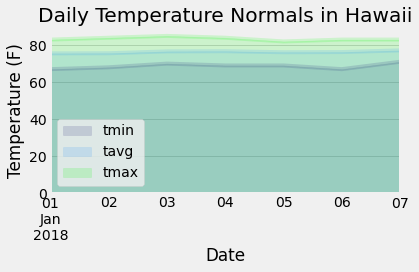

In [486]:
# Plot the daily normals as an area plot with `stacked=False`
dataframe.plot(kind='area', stacked=False, alpha=.15, color=['midnightblue','dodgerblue','lime'])
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Daily Temperature Normals in Hawaii")
plt.tight_layout()
plt.savefig('Output/Hawaii_Temperature_Normals.png')


In [462]:
session.close()